<a href="https://colab.research.google.com/github/dimLMT/Metabolic-Syndrome-Forecast/blob/main/part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 # Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Sklearn Display
from sklearn import set_config
set_config(transform_output='pandas')
# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [2]:
import joblib
# Confirm the file was saved by loading it back in
loaded = joblib.load('/content/drive/MyDrive/CodingDojo/05-IntermediateML/Week17/Data/part1.joblib')
loaded.keys()

dict_keys(['X_train_tf', 'y_train', 'X_test_tf', 'y_test', 'model', 'permutation_importances', 'X', 'y'])

In [3]:
# Loading data and objects in a new notebook
X_train_tf = loaded['X_train_tf']
y_train = loaded['y_train']
X_test_tf = loaded['X_test_tf']
y_test = loaded['y_test']
model = loaded['model']
permutation_importances = loaded['permutation_importances']
X = loaded['X']
y = loaded['y']

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues',cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train': results_train,
                    'test': results_test}
    return results_dict

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.99      1.00      0.99       616
   No MetSyn       1.00      0.99      1.00      1184

    accuracy                           1.00      1800
   macro avg       0.99      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



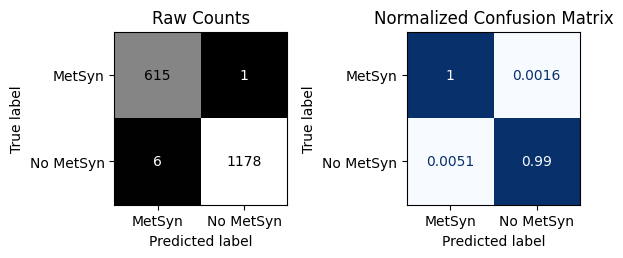

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.76      0.86      0.81       206
   No MetSyn       0.92      0.86      0.89       395

    accuracy                           0.86       601
   macro avg       0.84      0.86      0.85       601
weighted avg       0.87      0.86      0.86       601



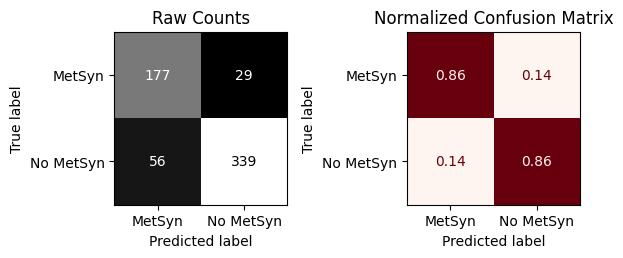

In [5]:
# restore last used model
results = evaluate_classification(model, X_train_tf, y_train, X_test_tf, y_test)

In [6]:
from sklearn.decomposition import PCA
# Instantiate Standard Scaler
scaler = StandardScaler()
# Fit & transform data.
X_train_tf = scaler.fit_transform(X_train_tf)
X_test_tf = scaler.transform(X_test_tf)

In [7]:
# Define PCA to address 85% of the variance
pca85 = PCA(n_components=.85)
# fit and transform on training data
X_train_pca85 = pca85.fit_transform(X_train_tf)
# transform test data
X_test_pca85 = pca85.transform(X_test_tf)
# obtain the number of PCs used
pca85.n_components_

14

In [8]:
from sklearn.ensemble import BaggingClassifier
# Instantiate a default Bagged Tree model
bagtree = BaggingClassifier(random_state = 42)
# Fit the model pipeline on the training data only
bagtree.fit(X_train_pca85, y_train)

BaggingClassifier(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.99      1.00      0.99       616
   No MetSyn       1.00      0.99      1.00      1184

    accuracy                           0.99      1800
   macro avg       0.99      1.00      0.99      1800
weighted avg       1.00      0.99      1.00      1800



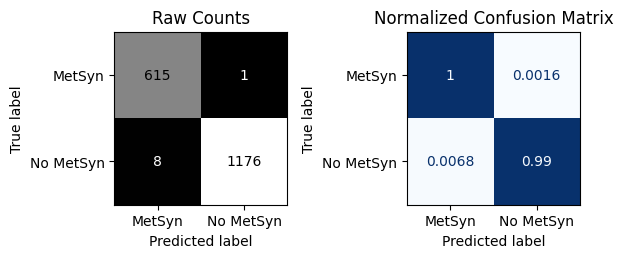

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      MetSyn       0.68      0.77      0.72       206
   No MetSyn       0.87      0.81      0.84       395

    accuracy                           0.80       601
   macro avg       0.78      0.79      0.78       601
weighted avg       0.81      0.80      0.80       601



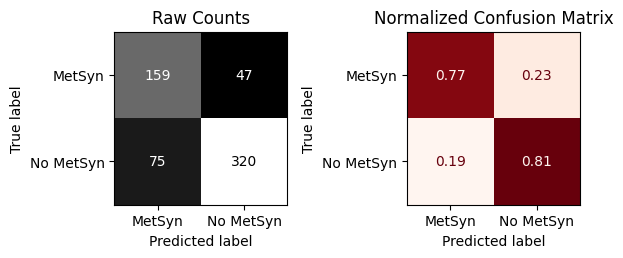

In [9]:
# Test the function
results = evaluate_classification(bagtree,X_train_pca85, y_train, X_test_pca85, y_test)